# Three layers tuning search.

We want to learn the best possible architecture for a 3 hidden layers DNN.
What the results show us is that, as we expect the training process to be longer and harder, the results are still not optimal great. The search space might be bad or simply, as we the input space suggests, the classification problem is too hard to be done on a such low scale of hidden units.

In [1]:
import os

# Why Torch? You'll find the answer in the .md files! 
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
# Dataset loading
from dataset.k_fold_dataset_wrapper import KFoldDatasetWrapper
from torch.utils.data import DataLoader
from dataset.dataset_loader import dataset_loader

train, test = dataset_loader((128, 128), is_grayscale=False)
dataset_split_controller = KFoldDatasetWrapper(5)
dataset_split_controller.load_data(train)

local_train, validation = dataset_split_controller.get_data_for_fold(0)
train_dataloader = DataLoader(dataset=local_train, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(dataset=validation, batch_size=16, shuffle=True)

In [3]:
import keras_tuner
from utils.my_tuner import HistoryDeletingBayesianOptimization
from models.naive_dnn_gen.naive_dnn import NaiveDNNTunableModelFamily
from models.structure.tunable_model_family_hypermodel import TunableModelFamilyHypermodel

# Top results:
# Reload the tuner.
tuner = HistoryDeletingBayesianOptimization(
    TunableModelFamilyHypermodel((3, 128, 128), NaiveDNNTunableModelFamily()),
    hyperparameters=keras_tuner.HyperParameters(), objective='val_loss',
    tune_new_entries=True, overwrite=False, directory="dnn-search",
    max_trials=15, project_name="three-layers"
)


Reloading Tuner from dnn-search/three-layers/tuner0.json


In [4]:
tuner.results_summary(5)

Results summary
Results in dnn-search/three-layers
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 12 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 1024
dropout_0: False
units_1: 32
dropout_1: False
units_2: 128
Score: 0.4633373022079468

Trial 09 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 512
dropout_0: False
units_1: 256
dropout_1: False
units_2: 256
Score: 0.46887969970703125

Trial 14 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 2048
dropout_0: True
units_1: 128
dropout_1: False
units_2: 32
Score: 0.46990901231765747

Trial 13 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 512
dropout_0: False
units_1: 128
dropout_1: True
units_2: 256
Score: 0.4733459949493408

Trial 07 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 256
dropout_0: False
units_1: 1024
dropout_1: False
units_2: 1024
Score: 0.4761548936367035


In [5]:
import pandas

# Prepare the pandas dataframe so we can see what trial has which iterations done.
csv = pandas.read_csv("./dnn-search/three-layers/search.log")
csv['tuner_iteration'] = 0

current_iteration = 0
for index, row in enumerate(csv.itertuples()):
    csv.at[index, 'tuner_iteration'] = int(index / 22)

best_dataframe = csv.query("tuner_iteration in [12]")

In [6]:
csv

,epoch,accuracy,loss,val_accuracy,val_loss,tuner_iteration
0,0,0.535601,0.685362,0.546453,0.675950,0
1,1,0.555039,0.671987,0.587838,0.657930,0
2,2,0.577858,0.658688,0.694257,0.652672,0
3,3,0.602155,0.655654,0.683277,0.629188,0
4,4,0.629833,0.638494,0.694257,0.619818,0
...,...,...,...,...,...,...
325,17,0.795056,0.438894,0.778716,0.479249,14
326,18,0.795901,0.437258,0.755068,0.524191,14
327,19,0.803296,0.437430,0.787162,0.469909,14
328,20,0.809635,0.423493,0.780405,0.472682,14


In [42]:
best_dataframe

,epoch,accuracy,loss,val_accuracy,val_loss,tuner_iteration
264,0,0.627509,0.633100,0.681588,0.586685,12
265,1,0.711388,0.571723,0.739865,0.538507,12
266,2,0.740123,0.534500,0.710304,0.549984,12
267,3,0.754067,0.510292,0.761824,0.512148,12
268,4,0.767801,0.491462,0.740709,0.536297,12
269,5,0.781111,0.468063,0.783784,0.490115,12
270,6,0.796958,0.453833,0.787162,0.476539,12
271,7,0.806888,0.438124,0.756757,0.512594,12
272,8,0.795690,0.445957,0.789696,0.469367,12
273,9,0.810057,0.428975,0.758446,0.518873,12


<Axes: >

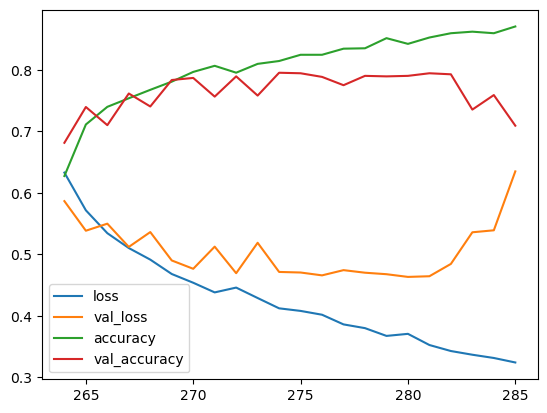

In [55]:
# The best model was hardly overfitting. There are no dropout layers on the model which might make performance better. (Trial 12)
# As the learning was steadily following the train accuracy we are probably missing units to better learn the structure.
# We could try to tune it with different combinations of dropout layers and maybe few more neurons.
best_dataframe[["loss", "val_loss", "accuracy", "val_accuracy"]].plot()
# This model is of no use if we dont change some of its structure

# Best configuration with dropout

In [44]:
# Trial 14 had some dropout layers. Could it have been still learning well? Remember we have no early stopping.
best_dataframe_with_dropout = csv.query("tuner_iteration in [14]")

In [45]:
best_dataframe_with_dropout

,epoch,accuracy,loss,val_accuracy,val_loss,tuner_iteration
308,0,0.594760,0.668526,0.664696,0.614495,14
309,1,0.652440,0.624056,0.635980,0.624046,14
310,2,0.682020,0.593473,0.688345,0.565942,14
311,3,0.704204,0.567939,0.696791,0.550941,14
312,4,0.724276,0.544091,0.760980,0.512528,14
313,5,0.738010,0.528427,0.764358,0.515501,14
314,6,0.755124,0.510587,0.771959,0.504866,14
315,7,0.754490,0.504921,0.747466,0.526626,14
316,8,0.763575,0.497672,0.765203,0.493132,14
317,9,0.764420,0.492682,0.779561,0.484756,14


<Axes: >

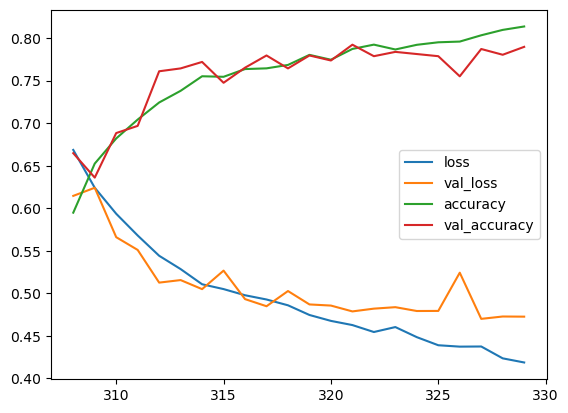

In [54]:
# This model might be worth to be still trained without putting hand on the parameters.
# We could still try to search for better parameters. (The neurons are prolly too few)
best_dataframe_with_dropout[["loss", "val_loss", "accuracy", "val_accuracy"]].plot()

In [7]:
import keras.optimizers
# Retrain the model with early stopping as it is. (K-fold will follow)
dropout_best_family = NaiveDNNTunableModelFamily()
dropout_best_family.load_parameters(tuner.get_best_hyperparameters(5)[2])
model = dropout_best_family.make_model((3, 128, 128))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), metrics=['accuracy'])

history = model.fit(train_dataloader, validation_data=validation_dataloader, epochs=150, callbacks=[keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='min', restore_best_weights=True
)])

Epoch 1/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - accuracy: 0.5531 - loss: 0.6959 - val_accuracy: 0.6822 - val_loss: 0.6280
Epoch 2/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.6465 - loss: 0.6210 - val_accuracy: 0.6610 - val_loss: 0.5992
Epoch 3/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.6731 - loss: 0.6078 - val_accuracy: 0.6610 - val_loss: 0.5866
Epoch 4/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 45s 188ms/step - accuracy: 0.7072 - loss: 0.5609 - val_accuracy: 0.6874 - val_loss: 0.5686
Epoch 5/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step - accuracy: 0.7201 - loss: 0.5591 - val_accuracy: 0.7043 - val_loss: 0.5525
Epoch 6/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 45s 190ms/step - accuracy: 0.7273 - loss: 0.5364 - val_accuracy: 0.7318 - val_loss: 0.5357
Epoch 7/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step - accuracy: 0.7418 - loss: 0.5202 - val_accuracy: 0.7318 - val_loss: 0.5212
Epoch 8/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 45s 192ms/step - accuracy: 0.7594 -

In [11]:
dataframe = pandas.DataFrame(history.history)
dataframe

,accuracy,loss,val_accuracy,val_loss
0,0.585578,0.672672,0.682154,0.627957
1,0.659007,0.613928,0.661035,0.599212
2,0.676704,0.602183,0.661035,0.586591
3,0.698362,0.575344,0.687434,0.568602
4,0.722927,0.555583,0.704329,0.552544
5,0.727417,0.543581,0.731785,0.535737
6,0.736133,0.528988,0.731785,0.521200
7,0.751189,0.516396,0.756072,0.494719
8,0.762810,0.502748,0.703273,0.575747
9,0.762810,0.499290,0.775079,0.478039


<Axes: >

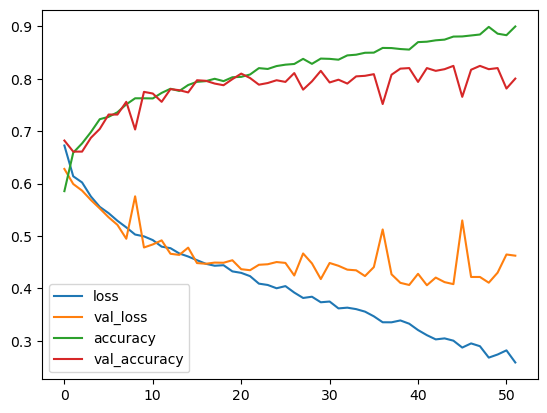

In [13]:
dataframe[["loss", "val_loss", "accuracy", "val_accuracy"]].plot()

In [25]:
from pprint import pprint

# The model doesnt look well. The gap in loss is noticable and the room for improvement was low. We could try using a pre-proecessing procedure on data to increase the sample size and also increase the neurons of the network.
print(tuner.get_best_hyperparameters(5)[2].values)
tuner.get_best_hyperparameters(5)[2].values['units_1'] = 1024
tuner.get_best_hyperparameters(5)[2].values['dropout_1'] = True
tuner.get_best_hyperparameters(5)[2].values['units_2'] = 248

{'lr': 0.0001, 'momentum': 0.9, 'layers': 3, 'units_0': 2048, 'dropout_0': True, 'units_1': 1024, 'dropout_1': False, 'units_2': 32}


In [27]:
import keras.optimizers
# Retrain the model with early stopping as it is. (K-fold will follow)
dropout_best_family = NaiveDNNTunableModelFamily()
dropout_best_family.load_parameters(tuner.get_best_hyperparameters(5)[2])
model = dropout_best_family.make_model((3, 128, 128))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), metrics=['accuracy'])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ naive_dnn (InputLayer)          │ (16, 3, 128, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (16, 49152)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (16, 2048)             │   100,665,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (16, 2048)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (16, 1024)             │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (16, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (16, 248)              │       254,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (16, 1)                │           249 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,017,969 (392.98 MB)

 Trainable params: 103,017,969 (392.98 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(train_dataloader, validation_data=validation_dataloader, epochs=150, callbacks=[keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='min', restore_best_weights=True
)])

Epoch 1/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - accuracy: 0.5222 - loss: 0.7858 - val_accuracy: 0.6494 - val_loss: 0.6553
Epoch 2/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.5817 - loss: 0.6877 - val_accuracy: 0.6315 - val_loss: 0.6465
Epoch 3/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - accuracy: 0.6109 - loss: 0.6705 - val_accuracy: 0.5026 - val_loss: 0.7167
Epoch 4/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.6071 - loss: 0.6605 - val_accuracy: 0.6526 - val_loss: 0.6324
Epoch 5/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.6467 - loss: 0.6309 - val_accuracy: 0.7033 - val_loss: 0.5925
Epoch 6/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.6494 - loss: 0.6193 - val_accuracy: 0.6811 - val_loss: 0.6122
Epoch 7/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.6677 - loss: 0.6071 - val_accuracy: 0.7149 - val_loss: 0.5691
Epoch 8/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.6745 -

In [29]:
dataframe = pandas.DataFrame(history.history)
dataframe

,accuracy,loss,val_accuracy,val_loss
0,0.535658,0.749011,0.649419,0.655330
1,0.578183,0.688255,0.631468,0.646489
2,0.617802,0.661593,0.502640,0.716693
3,0.630217,0.648578,0.652587,0.632400
4,0.643687,0.631669,0.703273,0.592464
...,...,...,...,...
56,0.830692,0.378676,0.805702,0.428046
57,0.842578,0.368039,0.790919,0.444784
58,0.834918,0.369375,0.806758,0.437821
59,0.846276,0.358163,0.795143,0.448315


In [35]:
import gc
import torch

# We learn slowly but we learn. We could try with augmentation. 80% on validation aint that bad.,
# Yet the model before performs in a kinda similar way so where went the complexity of our model?
torch.cuda.empty_cache()
gc.collect()


1764

In [36]:
# Per sfizio lo rendiamo immenso
print(tuner.get_best_hyperparameters(5)[2].values)
tuner.get_best_hyperparameters(5)[2].values['units_0'] = 3072
tuner.get_best_hyperparameters(5)[2].values['units_1'] = 1536
tuner.get_best_hyperparameters(5)[2].values['dropout_1'] = True
tuner.get_best_hyperparameters(5)[2].values['units_2'] = 256

import keras.optimizers
# Retrain the model with early stopping as it is. (K-fold will follow)
dropout_best_family = NaiveDNNTunableModelFamily()
dropout_best_family.load_parameters(tuner.get_best_hyperparameters(5)[2])
model = dropout_best_family.make_model((3, 128, 128))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), metrics=['accuracy'])

model.summary()

{'lr': 0.0001, 'momentum': 0.9, 'layers': 3, 'units_0': 3072, 'dropout_0': True, 'units_1': 1536, 'dropout_1': True, 'units_2': 256}


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ naive_dnn (InputLayer)          │ (16, 3, 128, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (16, 49152)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (16, 3072)             │   150,998,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (16, 3072)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (16, 1536)             │     4,720,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (16, 1536)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (16, 256)              │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (16, 1)                │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,111,873 (595.52 MB)

 Trainable params: 156,111,873 (595.52 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(train_dataloader, validation_data=validation_dataloader, epochs=150, callbacks=[keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='min', restore_best_weights=True
)])

Epoch 1/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 45s 191ms/step - accuracy: 0.5280 - loss: 0.7943 - val_accuracy: 0.6251 - val_loss: 0.6486
Epoch 2/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.5892 - loss: 0.6973 - val_accuracy: 0.6885 - val_loss: 0.6007
Epoch 3/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - accuracy: 0.6050 - loss: 0.6703 - val_accuracy: 0.6336 - val_loss: 0.6499
Epoch 4/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - accuracy: 0.6179 - loss: 0.6599 - val_accuracy: 0.6505 - val_loss: 0.6314
Epoch 5/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.6368 - loss: 0.6412 - val_accuracy: 0.7043 - val_loss: 0.5728
Epoch 6/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 45s 188ms/step - accuracy: 0.6789 - loss: 0.6039 - val_accuracy: 0.7202 - val_loss: 0.5711
Epoch 7/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.6693 - loss: 0.6081 - val_accuracy: 0.7202 - val_loss: 0.5548
Epoch 8/150
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.6886 -